## Model Fitting

Lets fit the Logestic Regression Model, Support vector Machine, Decision Tree, Neural Networks and the Deep Neural Networks(DNN) using keras models on this data-set and do the analysis and get the best model.

### Importing the packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import os
import tensorflow as tf
from __future__ import print_function
from tensorflow import keras
from tensorflow.keras import Model



# setting random seed to ensure that results are repeatable
np.random.seed(7026)

### Importing the train and test data set from the Data processing notebook

In [2]:
X_train=pd.read_csv("smoke_train_X.csv")
X_test=pd.read_csv("smoke_test_X.csv")
y_train=pd.read_csv("smoke_train_y.csv")
y_test=pd.read_csv("smoke_test_y.csv")

train_df=pd.read_csv("smoke_train_df.csv")
test_df=pd.read_csv("smoke_test_y.csv")

### Standardizing the variables

We standardize our variables to eliminate the differences in scale between the variables/attributes.

We will use the sklearn library's 'standard scaler' to accomplish this. The standard scaler function will standardize our variables. To achieve this, we will first need to train the scaler on the training data and then apply this trained scaler to standardize both the training and validation sets.

In [3]:
scaler = StandardScaler()
scaler.fit(X_train)

# Transform the predictors of training and test sets
X_train = scaler.transform(X_train) 
 

X_test = scaler.transform(X_test)


### Checking for the Imbalance in data

In [4]:
train_df.Fire_Alarm.value_counts()

1    31421
0    12420
Name: Fire_Alarm, dtype: int64

We can clearlly observe the data imbalance in this data so now lets do the undersampling

### Undersampling the data to get the balace in the data

The reason for undersampling is that there are more observations in the data. So, undersampling th data can acheive the data balance and also helps us remove extra data

Lets use the random under sampler to undersample the data

In [5]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [6]:
X_train,y_train=undersample.fit_resample(X_train,y_train)

In [7]:
y_train.value_counts()

Fire_Alarm
0             12420
1             12420
dtype: int64

Now the data is balanced

### Deciding on the best evalution metrices

Our main aim is to reduce the False Alarms which are nothing but the False Positives(Detected the smoke but there is actualy no smoke). But neglectng the False Negatives is even more dangerous as it doesn't detect smoke but there is actually smoke which could potentially be a fire.

Which means we have deal with both False Negatives and False Positives and the best evalution metric for this is **'F1 SCORE'**.
F1 score is the harmonic mean of Recall and precision so it deals with both false negatives and false postives

## Modeling

Lets Create a data frame to store the results of each model

In [8]:
performance = pd.DataFrame({"model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1": []})

### Logistic Regression Model

#### Logistic Regression model using Random Search and Grid Search

In [9]:
score_measure = "f1"
kfolds = 5

param_grid = {'C':[0.001,0.01,0.1,1,10], # C is the regulization strength
               'penalty':['l1', 'l2','elasticnet','none'],
              'solver':['saga','liblinear'],
              'max_iter': np.arange(500,1000)
                  
}

lg = LogisticRegression()
rand_search = RandomizedSearchCV(estimator =lg, param_distributions=param_grid, cv=kfolds, n_iter=500,
                           scoring=score_measure, verbose=1, n_jobs=-1  # n_jobs=-1 will utilize all available CPUs 
                                )

_ = rand_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {rand_search.best_score_}")
print(f"... with parameters: {rand_search.best_params_}")

bestlogestic = rand_search.best_estimator_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


C:\Users\ajayk\anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
1020 fits failed out of a total of 2500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
355 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ajayk\anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ajayk\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "C:\Users\ajayk\anaconda3\envs\tf\lib\site-packages\sklearn\utils\parallel.py", line

The best f1 score is 0.9066978169406108
... with parameters: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 785, 'C': 10}


C:\Users\ajayk\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [10]:
score_measure = "f1"
kfolds = 5
best_penality = rand_search.best_params_['penalty']
best_solver = rand_search.best_params_['solver']
min_regulization_strength=rand_search.best_params_['C']
min_iter = rand_search.best_params_['max_iter']

#Using the best parameters from the Random Search to use as range for the parameters to do the grid search
param_grid = {
    
    'C':np.arange(min_regulization_strength-0.05,min_regulization_strength+0.05), 
               'penalty':[best_penality],
              'solver':[best_solver],
              'max_iter': np.arange(min_iter-300,min_iter+300)
}

lgr =  LogisticRegression()
grid_search = GridSearchCV(estimator = lgr, param_grid=param_grid, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1 # n_jobs=-1 will utilize all available CPUs 
                )

_ = grid_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {grid_search.best_score_}")
print(f"... with parameters: {grid_search.best_params_}")

bestlgr = grid_search.best_estimator_

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


C:\Users\ajayk\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The best f1 score is 0.90672653110977
... with parameters: {'C': 9.95, 'max_iter': 721, 'penalty': 'l2', 'solver': 'saga'}


C:\Users\ajayk\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [11]:
c_matrix = confusion_matrix(y_test, grid_search.predict(X_test))
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
print(f"Accuracy={(TP+TN)/(TP+TN+FP+FN):.7f} Precision={TP/(TP+FP):.7f} Recall={TP/(TP+FN):.7f} F1={2*TP/(2*TP+FP+FN):.7f}")
F1_lr=2*TP/(2*TP+FP+FN)

Accuracy=0.9052637 Precision=0.9638728 Recall=0.9002699 F1=0.9309864


In [12]:
print(f"The F1 score from the Logestic Regression model using Random Search and Grid Search is :{F1_lr}")

The F1 score from the Logestic Regression model using Random Search and Grid Search is :0.9309863523573201


In [13]:
performance = pd.concat([performance, pd.DataFrame({'model':"logistic using random & grid search", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

### SVM model

#### SVM using RandomSearch and Grid Search

In [14]:
score_measure = "f1"
kfolds = 3

param_grid = {'C':np.arange(0.1,100,10),  #  regularization parameter.
               'kernel':['linear', 'rbf','poly'],
              'gamma':['scale','auto'],
              'degree':np.arange(1,10), #degree is for the polynomial kernal
              'coef0':np.arange(1,10) #coef0 is for the polynomial kernal
                  
}

svc = SVC()
rand_search = RandomizedSearchCV(estimator =svc, param_distributions=param_grid, cv=kfolds, n_iter=500,
                           scoring=score_measure, verbose=1, n_jobs=-1  # n_jobs=-1 will utilize all available CPUs 
                                )

_ = rand_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {rand_search.best_score_}")
print(f"... with parameters: {rand_search.best_params_}")

bestsvc = rand_search.best_estimator_

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


C:\Users\ajayk\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The best f1 score is 0.9995170442896705
... with parameters: {'kernel': 'poly', 'gamma': 'auto', 'degree': 3, 'coef0': 8, 'C': 90.1}


In [15]:
score_measure = "f1"
kfolds = 3
best_kernel = rand_search.best_params_['kernel']
best_gamma = rand_search.best_params_['gamma']
min_regulization=rand_search.best_params_['C']
best_degree = rand_search.best_params_['degree']
best_coef0=rand_search.best_params_['coef0']

#Using the best parameters from the Random Search to use as range for the parameters to do the grid search
param_grid = {
    
    'C':np.arange(min_regulization-3,min_regulization+3), 
               'kernel':[best_kernel],
              'gamma':[best_gamma],
              'degree': np.arange(best_degree-1,best_degree+1),
            'coef0': np.arange(best_coef0-3,best_coef0+3)
}

svm_grid =  SVC()
grid_search = GridSearchCV(estimator = svm_grid, param_grid=param_grid, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1 # n_jobs=-1 will utilize all available CPUs 
                )

_ = grid_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {grid_search.best_score_}")
print(f"... with parameters: {grid_search.best_params_}")

best_svm = grid_search.best_estimator_

Fitting 3 folds for each of 72 candidates, totalling 216 fits


C:\Users\ajayk\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The best f1 score is 0.9995170442896705
... with parameters: {'C': 87.1, 'coef0': 8, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}


In [16]:
c_matrix = confusion_matrix(y_test, grid_search.predict(X_test))
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
print(f"Accuracy={(TP+TN)/(TP+TN+FP+FN):.7f} Precision={TP/(TP+FP):.7f} Recall={TP/(TP+FN):.7f} F1={2*TP/(2*TP+FP+FN):.7f}")
F1_svm=2*TP/(2*TP+FP+FN)

Accuracy=0.9995210 Precision=0.9997000 Recall=0.9996251 F1=0.9996626


In [17]:
print(f"The f1 score from the SVM model using Random Search and Grid Search is {F1_svm}")

The f1 score from the SVM model using Random Search and Grid Search is 0.9996625548348393


In [18]:
performance = pd.concat([performance, pd.DataFrame({'model':"svm using Random & Grid search", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

### Decision Trees

#### Decision Trees using RandomSearchCV combined with GridSearchCV

In [19]:
score_measure = "f1"
kfolds = 5

param_grid = {
    'min_samples_split': np.arange(1,100),  
    'min_samples_leaf': np.arange(1,100),
    'min_impurity_decrease': np.arange(0.0001, 0.0005),
    'max_leaf_nodes': np.arange(5, 100), 
    'max_depth': np.arange(1,25), 
    'criterion': ['entropy', 'gini'],
}

dtree = DecisionTreeClassifier()
rand_search = RandomizedSearchCV(estimator = dtree, param_distributions=param_grid, cv=kfolds, n_iter=500,
                           scoring=score_measure, verbose=1, n_jobs=-1,  # n_jobs=-1 will utilize all available CPUs 
                           return_train_score=True)

_ = rand_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {rand_search.best_score_}")
print(f"... with parameters: {rand_search.best_params_}")

bestRecallTree = rand_search.best_estimator_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


C:\Users\ajayk\anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 2500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ajayk\anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ajayk\anaconda3\envs\tf\lib\site-packages\sklearn\tree\_classes.py", line 889, in fit
    super().fit(
  File "C:\Users\ajayk\anaconda3\envs\tf\lib\site-packages\sklearn\tree\_classes.py", line 177, in fit
    self._validate_params()
  File "C:\Users\ajayk\anaconda3\envs\tf\

The best f1 score is 0.9993156117159033
... with parameters: {'min_samples_split': 2, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0001, 'max_leaf_nodes': 95, 'max_depth': 18, 'criterion': 'gini'}


In [20]:
score_measure = "f1"
kfolds = 5
min_samples_split = rand_search.best_params_['min_samples_split']
min_samples_leaf = rand_search.best_params_['min_samples_leaf']
min_impurity_decrease = rand_search.best_params_['min_impurity_decrease']
max_leaf_nodes = rand_search.best_params_['max_leaf_nodes']
max_depth = rand_search.best_params_['max_depth']
criterion = rand_search.best_params_['criterion']
#Using the best parameters from the Random Search to use as range for the parameters to do the grid search
param_grid = {
    'min_samples_split': np.arange(min_samples_split-2,min_samples_split+2),  
    'min_samples_leaf': np.arange(min_samples_leaf-2,min_samples_leaf+2),
    'min_impurity_decrease': np.arange(min_impurity_decrease-0.0001, min_impurity_decrease+0.0001, 0.00005),
    'max_leaf_nodes': np.arange(max_leaf_nodes-2,max_leaf_nodes+2), 
    'max_depth': np.arange(max_depth-2,max_depth+2), 
    'criterion': [criterion]
}

dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid=param_grid, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1,  # n_jobs=-1 will utilize all available CPUs 
                           return_train_score=True)

_ = grid_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {grid_search.best_score_}")
print(f"... with parameters: {grid_search.best_params_}")

bestRecallTree = grid_search.best_estimator_

Fitting 5 folds for each of 1024 candidates, totalling 5120 fits


C:\Users\ajayk\anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
3200 fits failed out of a total of 5120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1280 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ajayk\anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ajayk\anaconda3\envs\tf\lib\site-packages\sklearn\tree\_classes.py", line 889, in fit
    super().fit(
  File "C:\Users\ajayk\anaconda3\envs\tf\lib\site-packages\sklearn\tree\_classes.py", line 177, in fit
    self._validate_params()
  File "C:\Users\ajayk\anaconda3\envs

The best f1 score is 0.9995973910381597
... with parameters: {'criterion': 'gini', 'max_depth': 18, 'max_leaf_nodes': 94, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [21]:
c_matrix = confusion_matrix(y_test, grid_search.predict(X_test))
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
print(f"Accuracy={(TP+TN)/(TP+TN+FP+FN):.7f} Precision={TP/(TP+FP):.7f} Recall={TP/(TP+FN):.7f} F1={2*TP/(2*TP+FP+FN):.7f}")
F1_Decisiontree=2*TP/(2*TP+FP+FN)

Accuracy=0.9997871 Precision=0.9998500 Recall=0.9998500 F1=0.9998500


In [22]:
print(f"The f1 score from the Decision Tree using Random Search and Grid Search is {F1_Decisiontree}")

The f1 score from the Decision Tree using Random Search and Grid Search is 0.9998500299940012


In [23]:
performance = pd.concat([performance, pd.DataFrame({'model':"Decision Tree", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])


## Neural Network

#### Without Randomsearch and gridsearch cv

In [24]:
%%time

ann = MLPClassifier(hidden_layer_sizes=(60,50,40), solver='adam', max_iter=200)
_ = ann.fit(X_train,np.ravel( y_train))

CPU times: total: 38.7 s
Wall time: 17.4 s


In [25]:
%%time
y_pred = ann.predict(X_test)

CPU times: total: 62.5 ms
Wall time: 42 ms


In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5453
           1       1.00      1.00      1.00     13336

    accuracy                           1.00     18789
   macro avg       1.00      1.00      1.00     18789
weighted avg       1.00      1.00      1.00     18789



## With RandomizedSearchCV

In [27]:
%%time

score_measure = "f1"
kfolds = 5

param_grid = {
    'hidden_layer_sizes': [ (50,), (70,),(50,30), (40,20),(60,60,60), (60,70, 80), (70,50,40)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [0, .2, .5, .7, 1],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1, 0.2, 0.5],
    'max_iter': [3000]
}

ann = MLPClassifier()
grid_search = RandomizedSearchCV(estimator = ann, param_distributions=param_grid, cv=kfolds, n_iter=100,
                           scoring=score_measure, verbose=1, n_jobs=-1,  # n_jobs=-1 will utilize all available CPUs 
                           return_train_score=True)

_ = grid_search.fit(X_train, y_train)

bestRecallTree = grid_search.best_estimator_

print(grid_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\ajayk\anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
1 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ajayk\anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ajayk\anaconda3\envs\tf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 749, in fit
    return self._fit(X, y, incremental=False)
  File "C:\Users\ajayk\anaconda3\envs\tf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 491, in

{'solver': 'sgd', 'max_iter': 3000, 'learning_rate_init': 0.01, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (70, 50, 40), 'alpha': 0, 'activation': 'relu'}
CPU times: total: 1min 9s
Wall time: 24min 27s


In [28]:
%%time
y_pred = bestRecallTree.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5453
           1       1.00      1.00      1.00     13336

    accuracy                           1.00     18789
   macro avg       1.00      1.00      1.00     18789
weighted avg       1.00      1.00      1.00     18789

CPU times: total: 109 ms
Wall time: 59.1 ms


## With GridSearchCV

In [29]:
%%time

score_measure = "f1"
kfolds = 5

param_grid = {
    'hidden_layer_sizes': [ (50,30), (50,70), (50,90)],
    'activation': ['logistic', 'relu'],
    'solver': ['sgd'],
    'alpha': [0,.5 ],
    'learning_rate': ['adaptive', 'invscaling'],
    'learning_rate_init': [0.1,0.2,0.25],
    'max_iter': [5000]
}

ann = MLPClassifier()
grid_search = GridSearchCV(estimator = ann, param_grid=param_grid, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1,  # n_jobs=-1 will utilize all available CPUs 
                           return_train_score=True)

_ = grid_search.fit(X_train, y_train)

bestRecallTree = grid_search.best_estimator_

print(grid_search.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


C:\Users\ajayk\anaconda3\envs\tf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'activation': 'relu', 'alpha': 0, 'hidden_layer_sizes': (50, 90), 'learning_rate': 'adaptive', 'learning_rate_init': 0.25, 'max_iter': 5000, 'solver': 'sgd'}
CPU times: total: 1min 35s
Wall time: 26min 4s


In [30]:
%%time
y_pred = bestRecallTree.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.99      0.88      5453
           1       0.99      0.90      0.94     13336

    accuracy                           0.92     18789
   macro avg       0.89      0.94      0.91     18789
weighted avg       0.94      0.92      0.92     18789

CPU times: total: 344 ms
Wall time: 148 ms


In [31]:
c_matrix = confusion_matrix(y_test, y_pred)
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
print(f"Accuracy={(TP+TN)/(TP+TN+FP+FN):.7f} Precision={TP/(TP+FP):.7f} Recall={TP/(TP+FN):.7f} F1={2*TP/(2*TP+FP+FN):.7f}")
F1_lr=2*TP/(2*TP+FP+FN)



Accuracy=0.9225611 Precision=0.9938482 Recall=0.8964457 F1=0.9426375


In [32]:
print(f"The F1 score from the Neural Networks model using Random Search and Grid Search is :{F1_lr}")



The F1 score from the Neural Networks model using Random Search and Grid Search is :0.9426374926079243


In [33]:
performance = pd.concat([performance, pd.DataFrame({'model':"neural network using random & grid search", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

## Keras with SKlearn

In [38]:
%%time

# If you don't have the following installed, from command line '!pip install scikeras'
from scikeras.wrappers import KerasClassifier
from keras.initializers import GlorotNormal

score_measure = "f1"
kfolds = 5

def build_clf(hidden_layer_sizes, dropout):
    ann = tf.keras.models.Sequential()
    ann.add(keras.layers.Input(shape=12)),
    for hidden_layer_size in hidden_layer_sizes:
        ann.add(keras.layers.Dense(hidden_layer_size, kernel_initializer= tf.keras.initializers.GlorotUniform(), 
                                     bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None), activation="relu"))
        ann.add(keras.layers.Dropout(dropout))
    ann.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    #the out is either 0 or 1 which is single numeric value, like a regression task so the tensor shape is (None,1)
    
    ann.compile(loss = 'binary_crossentropy', metrics = ['accuracy'])
    return ann


CPU times: total: 0 ns
Wall time: 0 ns


For more information on dense layers and initializers, see the following:
* https://keras.io/api/layers/core_layers/dense/
* https://keras.io/api/layers/initializers/

In [39]:
from scikeras.wrappers import KerasClassifier

keras_clf = KerasClassifier(
    model=build_clf,
    hidden_layer_sizes=64,
    dropout = 0.0
)


In [40]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV

params = {
    'optimizer__learning_rate': [0.0005, 0.001, 0.005],
    'model__hidden_layer_sizes': [(70,),(90, ), (100,), (100, 90)],
    'model__dropout': [0, 0.1],
    'batch_size':[20, 60, 100],
    'epochs':[10, 50, 100],
    'optimizer':["adam",'sgd']
}
keras_clf.get_params().keys()



dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'hidden_layer_sizes', 'dropout', 'class_weight'])

In [41]:
rnd_search_cv = RandomizedSearchCV(estimator=keras_clf, param_distributions=params, scoring='f1', n_iter=50, cv=5)

import sys
sys.setrecursionlimit(10000) # note: the default is 3000 (python 3.9)

earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
callback = [earlystop]

_ = rnd_search_cv.fit(X_train, y_train, callbacks=callback, verbose=0)


50/50 [==============================] - 0s 2ms/step


In [42]:
rnd_search_cv.best_params_

{'optimizer__learning_rate': 0.0005,
 'optimizer': 'sgd',
 'model__hidden_layer_sizes': (100, 90),
 'model__dropout': 0.1,
 'epochs': 100,
 'batch_size': 100}

In [43]:
best_net = rnd_search_cv.best_estimator_
print(rnd_search_cv.best_params_)

{'optimizer__learning_rate': 0.0005, 'optimizer': 'sgd', 'model__hidden_layer_sizes': (100, 90), 'model__dropout': 0.1, 'epochs': 100, 'batch_size': 100}


In [44]:
%%time
y_pred = best_net.predict(X_test)
print(classification_report(y_test, y_pred))

188/188 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5453
           1       1.00      1.00      1.00     13336

    accuracy                           1.00     18789
   macro avg       1.00      1.00      1.00     18789
weighted avg       1.00      1.00      1.00     18789

CPU times: total: 3.84 s
Wall time: 1.09 s


188/188 [==============================] - 0s 1ms/step


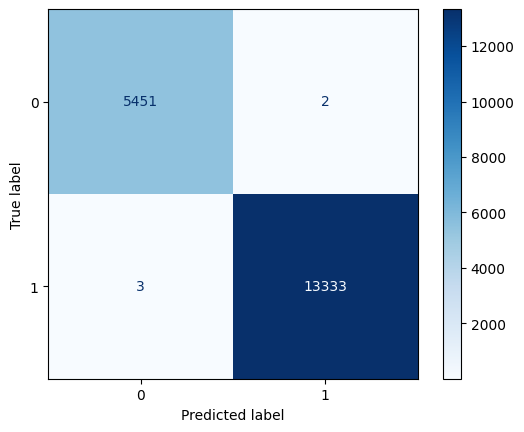

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, best_net.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Here we can clreally observe that the model is predicting the output soo good that we have very less false postives and flase negatives in the confusion matrix

In [47]:
c_matrix = confusion_matrix(y_test, y_pred)
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
print(f"Accuracy={(TP+TN)/(TP+TN+FP+FN):.7f} Precision={TP/(TP+FP):.7f} Recall={TP/(TP+FN):.7f} F1={2*TP/(2*TP+FP+FN):.7f}")
F1_lr=2*TP/(2*TP+FP+FN)



Accuracy=0.9997339 Precision=0.9998500 Recall=0.9997750 F1=0.9998125


In [48]:
print(f"The F1 score from the Deep Neural Networks model using keras is :{F1_lr}")



The F1 score from the Deep Neural Networks model using keras is :0.9998125304637996


In [49]:
performance = pd.concat([performance, pd.DataFrame({'model':"deep neural network using keras with sklearn", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

## Conclusion

In [50]:
performance

,model,Accuracy,Precision,Recall,F1
0,logistic using random & grid search,0.905264,0.963873,0.900270,0.930986
0,svm using Random & Grid search,0.999521,0.999700,0.999625,0.999663
0,Decision Tree,0.999787,0.999850,0.999850,0.999850
0,neural network using random & grid search,0.922561,0.993848,0.896446,0.942637
0,deep neural network using keras with sklearn,0.999734,0.999850,0.999775,0.999813


We can clearlly observ that the F1 score of the Decision Tree and deep neural networks uisng keras are much higher when comapred to other models. But in general, DNN's using Keras will provide higher accuracy than decision trees for complex and high-dimensional data.Even though the decision trees are faster and more interpretable than DNN's as our data is large and more complex so lets consider the DNN's as the best model.

So, the best model that has less False Positives(False Alarms) and False Negatives(Smoke is there but Detected that there is no smoke) is **Deep Neural Networks using keras**. 

Now that we have our best model we can deploye this into an AI based smoke detector and it can predict the smoke with less False Negatives and False Postives.